In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import pyarrow.parquet as pq
import sys
import torch
import random
import torch.nn as nn
import torch.nn.functional as F
import math
from IPython.display import clear_output

import matplotlib.pyplot as plt

sys.path.append('../../../')
from configs.data_configs.rosbank import data_configs
from configs.model_configs.mTAN.rosbank import model_configs
from src.data_load.dataloader import create_data_loaders
from src.models.mTAND.model import MegaNet

In [2]:
conf = data_configs()
model_conf = model_configs()

In [3]:
df = pd.read_parquet(conf.train_path)
df.head()

,cl_id,amount,event_time,mcc,channel_type,currency,trx_category,trx_count,target_target_flag,target_target_sum
0,10018,"[10.609081944147828, 10.596659732783579, 10.81...","[17120.38773148148, 17133.667800925927, 17134....","[13, 2, 13, 2, 1, 18, 13, 2, 13, 2, 5, 13, 9, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]","[5, 3, 5, 3, 1, 1, 5, 3, 5, 3, 1, 5, 5, 5, 5]",15,0,0.0
1,10030,"[4.61512051684126, 6.90875477931522, 10.598857...","[17141.0, 17141.0, 17145.0, 17147.0, 17147.0, ...","[9, 9, 21, 1, 25, 6, 14, 14, 3, 3, 3, 13, 1, 3...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 1, 7, 1, 1, 3, ...",42,1,59.51
2,10038,"[7.4127640174265625, 7.370230641807081, 7.8180...","[17301.0, 17301.0, 17301.0, 17301.774780092594...","[1, 1, 1, 2, 2, 4, 2, 8, 1, 22, 8, 1, 8, 4, 2,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 2, 2, 1, 3, 1, 1, 1, 1, 1, 1, 1, 2, ...",111,0,0.0
3,10057,"[7.494708263135679, 7.736394428979239, 10.7789...","[17151.0, 17151.0, 17153.0, 17154.0, 17155.0, ...","[6, 21, 2, 6, 2, 4, 2, 22, 15, 2, 1, 35, 4, 2,...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 4, 1, 4, 1, 3, 1, 1, 3, 1, 1, 1, 4, 1, ...",61,1,62961.31
4,10062,"[8.31898612539206, 8.824824939175638, 6.509067...","[17143.0, 17143.0, 17143.0, 17144.0, 17144.0, ...","[80, 15, 37, 38, 11, 11, 2, 24, 7, 5, 5, 11, 1...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, ...",82,1,107126.35


In [4]:
#df.loc[:32].to_parquet('../data/train_subset.parquet')

In [5]:
train_loader, valid_loader = create_data_loaders(conf)

33it [00:00, 6407.37it/s]


In [12]:
for batch in train_loader:
    break

In [13]:
net = MegaNet(model_conf=model_conf, data_conf=conf)

In [14]:
out = net(batch[0])

In [15]:
out.keys()

dict_keys(['x_recon', 'z', 'x', 'time_steps', 'mu', 'log_std'])

In [16]:
out['x_recon'].size()

torch.Size([5, 20, 100, 65])

In [17]:
loss_out = net.loss(out)

In [18]:
loss_out

{'elbo_loss': tensor(137271.9688, grad_fn=<AddBackward0>),
 'kl_loss': tensor(7.8348, grad_fn=<MeanBackward0>),
 'recon_loss': tensor(137271.1875, grad_fn=<MeanBackward0>)}

In [6]:
def perform_epoch(model, batch, optimizer):
    optimizer.zero_grad()
    out = model(batch[0])
    loss = model.loss(out)
    loss['elbo_loss'].backward()
    optimizer.step

    return loss

def train(model, loader, optimizer, num_epochs):

    model.train()
    recon_loss = []
    kl_loss = []
    for epoch in range(num_epochs):
        for i, batch in tqdm(enumerate(loader), total=len(loader)):
            loss = perform_epoch(model, batch, optimizer)
            recon_loss.append(loss['recon_loss'].detach().item())
            kl_loss.append(loss['kl_loss'].detach().item())

            if (i+1) % 1 == 0:
                plot_losses(recon_loss, kl_loss)


def plot_losses(recon_loss, kl_loss):
    clear_output(True)
    plt.plot(np.log(recon_loss), color='g', label='recon')
    plt.plot(kl_loss, color='r', label='kl')
    plt.legend()   
    plt.show() 

In [7]:
lr = 3e-2
net = MegaNet(model_conf=model_conf, data_conf=conf)
optimizer = torch.optim.Adam(net.parameters(), lr=lr)


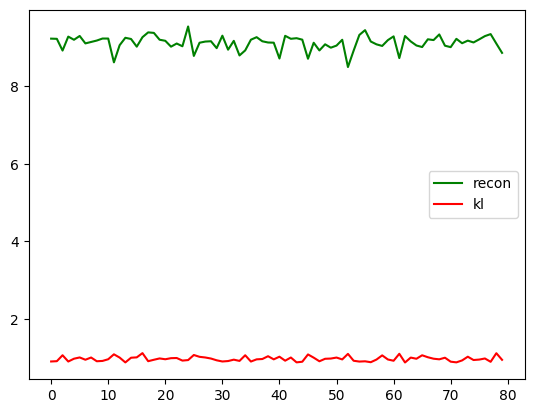

100%|██████████| 8/8 [00:01<00:00,  4.60it/s]


In [8]:
train(net, train_loader, optimizer, 10)

In [27]:
kl_loss = [3, 2, 1]
recon_loss = [7, 5, 2]

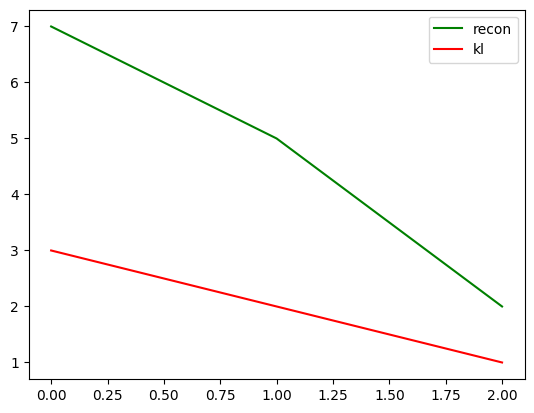

In [28]:
plot_losses(recon_loss, kl_loss)